In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

image_path = os.path.join("/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png")
mask_path = os.path.join("/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/","masks/")

In [ ]:
from PIL import Image, ImageFilter

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

Using TensorFlow backend.


#### Compile and train the Unet Model

In [ ]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
model.load_weights('/kaggle/input/cxr-reg-weights-best/cxr_reg_weights.best.hdf5')

In [ ]:
from scipy import misc
import glob

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


(224, 224, 3)
uint8


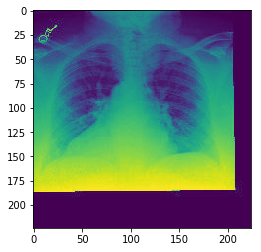

In [ ]:
from scipy import misc
import glob

#for image_path in glob.glob("/kaggle/input/lungs150/rl00000073.pkl_10020309.jpg"):
for image_path in glob.glob("/kaggle/input/lungs150/rl00000469.pkl_10154271_2.jpg"):
    image = misc.imread(image_path)
    print(image.shape)
    print(image.dtype)
    plt.imshow(image[:,:,0], interpolation='nearest')

<class 'numpy.ndarray'>
(512, 512, 1)


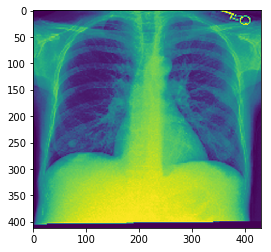

In [ ]:
loaded = np.load('/kaggle/input/conv-picke-00000000-npz/conv_picke_00000000.npz')
loaded_picke = loaded['y']
print(type(loaded_picke))
print(np.shape(loaded_picke))
plt.imshow(loaded_picke[40:-60,40:-40,0], interpolation='nearest')
loaded_picke = cv2.resize(loaded_picke[40:-40,40:-60,0], dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

(512, 512)


Text(0.5,0,'Pridiction')

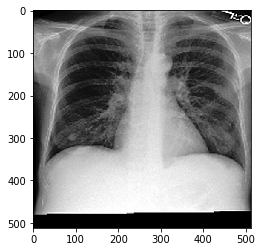

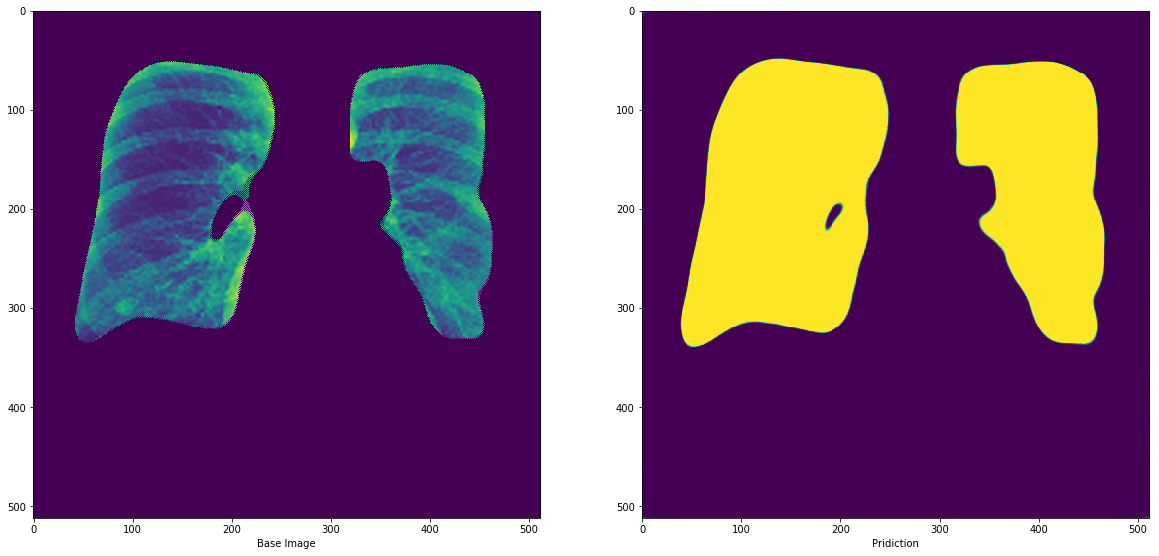

In [ ]:
sharp_img = Image.fromarray(loaded_picke[:,:]).filter(ImageFilter.SHARPEN)
plt.imshow(sharp_img, interpolation='nearest')
dim = 512
print(np.shape(loaded_picke))
loaded_picke_add_dim = np.array(loaded_picke).reshape(1,dim,dim,1)
#loaded_picke_add_dim = np.expand_dims(loaded_picke, axis=0)
np.shape(loaded_picke_add_dim)
preds = model.predict(loaded_picke_add_dim/ 255)

plt.figure(figsize=(20,10))
i = 0
plt.subplot(1,2,i+1)

plt.imshow(np.squeeze(np.where(preds[0]==1,loaded_picke_add_dim/ 255,0)))
plt.xlabel("Base Image")

plt.subplot(1,2,i+2)
plt.imshow(np.squeeze(preds[0]))
plt.xlabel("Pridiction")

(512, 512)


Text(0.5,0,'Pridiction')

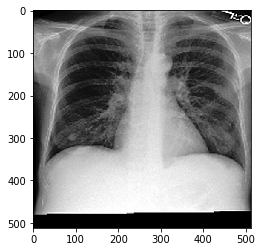

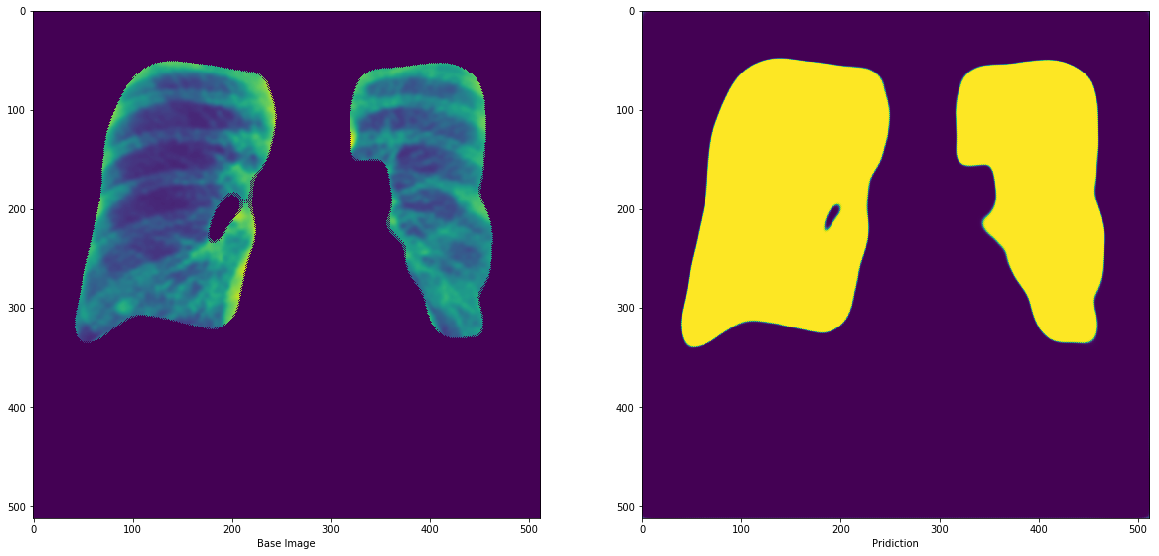

In [ ]:
import cv2
loaded_picke = cv2.GaussianBlur(loaded_picke, ksize=(11, 11), sigmaX =0, sigmaY=0)

plt.imshow(sharp_img, interpolation='nearest')
dim = 512
print(np.shape(loaded_picke))
loaded_picke_add_dim = np.array(loaded_picke).reshape(1,dim,dim,1)
#loaded_picke_add_dim = np.expand_dims(loaded_picke, axis=0)
np.shape(loaded_picke_add_dim)
preds = model.predict(loaded_picke_add_dim/ 255)

plt.figure(figsize=(20,10))
i = 0
plt.subplot(1,2,i+1)

plt.imshow(np.squeeze(np.where(preds[0]==1,loaded_picke_add_dim/ 255,0)))
plt.xlabel("Base Image")

plt.subplot(1,2,i+2)
plt.imshow(np.squeeze(preds[0]))
plt.xlabel("Pridiction")

(512, 512)


Text(0.5,0,'Pridiction')

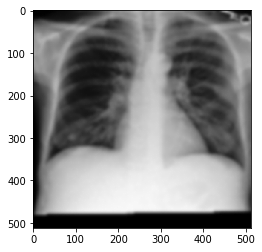

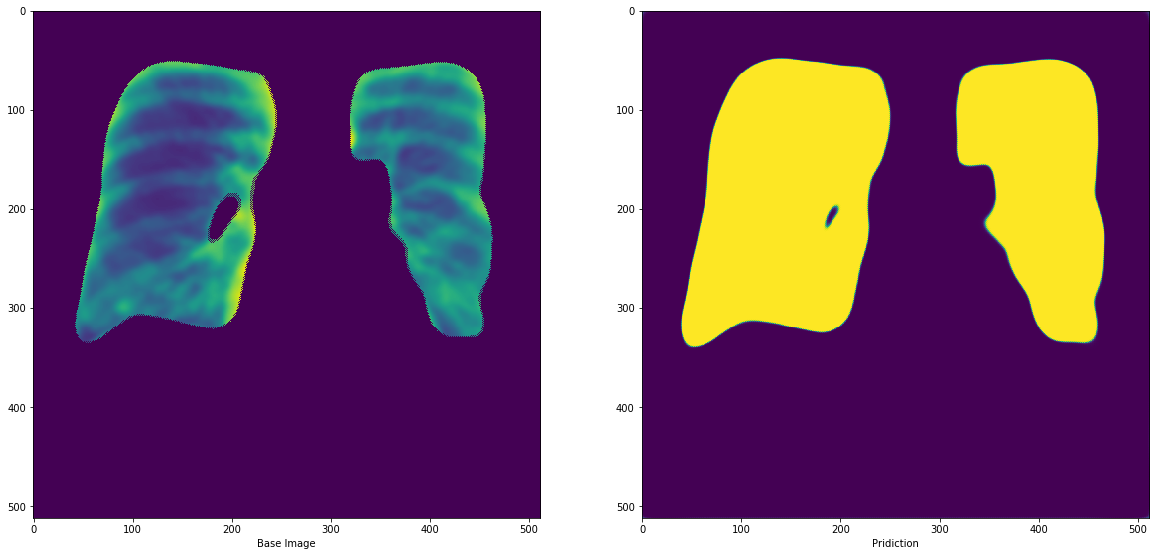

In [ ]:
import cv2
loaded_picke = cv2.GaussianBlur(loaded_picke, ksize=(11, 11), sigmaX =0, sigmaY=0)
sharp_img = Image.fromarray(loaded_picke).filter(ImageFilter.SHARPEN)

plt.imshow(sharp_img, interpolation='nearest')
dim = 512
print(np.shape(loaded_picke))
loaded_picke_add_dim = np.array(loaded_picke).reshape(1,dim,dim,1)
#loaded_picke_add_dim = np.expand_dims(loaded_picke, axis=0)
np.shape(loaded_picke_add_dim)
preds = model.predict(loaded_picke_add_dim/ 255)

plt.figure(figsize=(20,10))
i = 0
plt.subplot(1,2,i+1)

plt.imshow(np.squeeze(np.where(preds[0]==1,loaded_picke_add_dim/ 255,0)))
plt.xlabel("Base Image")

plt.subplot(1,2,i+2)
plt.imshow(np.squeeze(preds[0]))
plt.xlabel("Pridiction")

In [ ]:
loaded_picke = cv2.GaussianBlur(loaded_picke, ksize=(11, 11), sigmaX =0, sigmaY=0)

(512, 512)


Text(0.5,0,'Pridiction')

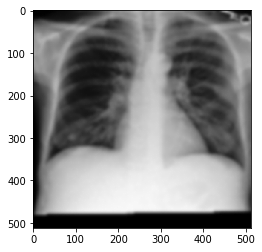

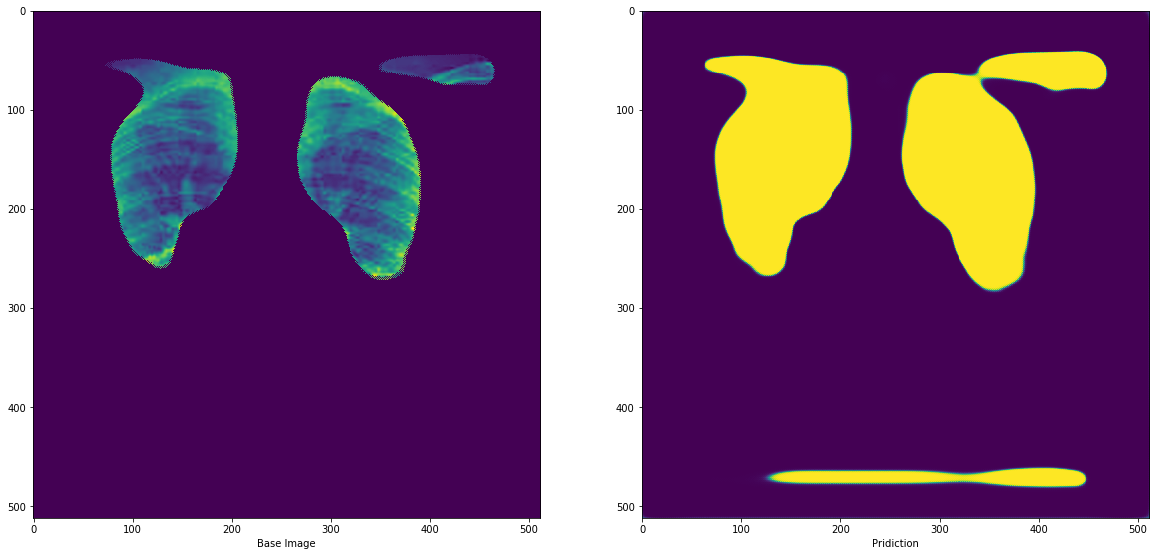

In [ ]:
import cv2
loaded_picke = cv2.resize(image[:420,:475,1], dsize=(512, 512), interpolation=cv2.INTER_CUBIC)

plt.imshow(sharp_img, interpolation='nearest')
dim = 512
print(np.shape(loaded_picke))
loaded_picke_add_dim = np.array(loaded_picke).reshape(1,dim,dim,1)
#loaded_picke_add_dim = np.expand_dims(loaded_picke, axis=0)
np.shape(loaded_picke_add_dim)
preds = model.predict(loaded_picke_add_dim/ 255)

plt.figure(figsize=(20,10))
i = 0
plt.subplot(1,2,i+1)

plt.imshow(np.squeeze(np.where(preds[0]==1,loaded_picke_add_dim/ 255,0)))
plt.xlabel("Base Image")

plt.subplot(1,2,i+2)
plt.imshow(np.squeeze(preds[0]))
plt.xlabel("Pridiction")

In [ ]:
#loaded_picke = loaded_picke[35:400,25:480]
dim = 512
print(np.shape(loaded_picke))
loaded_picke_add_dim = np.array(loaded_picke).reshape(1,dim,dim,1)
#loaded_picke_add_dim = np.expand_dims(loaded_picke, axis=0)
np.shape(loaded_picke_add_dim)

(512, 512, 1)


(1, 512, 512, 1)

In [ ]:
loaded_picke_add_dim = loaded_picke_add_dim.astype('float64')

Text(0.5,0,'Pridiction')

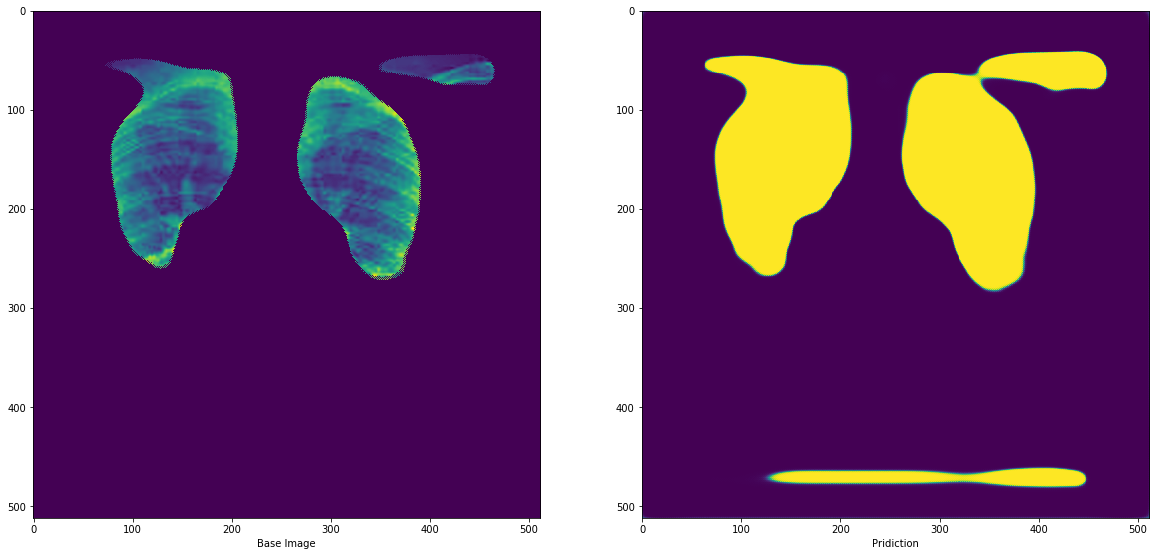

In [ ]:
#loaded_picke[35:400,25:480,0]
preds = model.predict(loaded_picke_add_dim/ 255)

plt.figure(figsize=(20,10))
i = 0
plt.subplot(1,2,i+1)

plt.imshow(np.squeeze(np.where(preds[0]==1,loaded_picke_add_dim/ 255,0)))
plt.xlabel("Base Image")

plt.subplot(1,2,i+2)
plt.imshow(np.squeeze(preds[0]))
plt.xlabel("Pridiction")

In [ ]:
from PIL import Image

In [ ]:
t = np.zeros([26,512,512,1])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


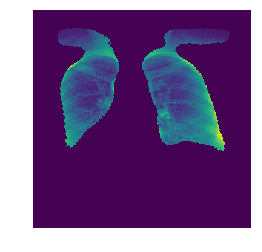

In [ ]:
i = 0
for image_path in glob.glob("/kaggle/input/lungs150/*.jpg"):
    dim = 512
    image = misc.imread(image_path)
    #plt.imshow(image[:,:,0], interpolation='nearest')
    loaded_picke = cv2.resize(image[:,:,0], dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
    loaded_picke_add_dim = np.array(loaded_picke).reshape(1,dim,dim,1)
    preds = model.predict(loaded_picke_add_dim/ 255)
    #plt.savefig()
    im = Image.fromarray(np.squeeze(np.where(preds[0]==1,loaded_picke_add_dim/ 255,0).astype(np.uint8)))
    plt.imshow(np.squeeze(np.where(preds[0]==1,loaded_picke_add_dim/ 255,0)), interpolation='nearest')
    if im.mode != 'RGB':
        im = im.convert('RGB')
    plt.axis('off')
    #plt.savefig("/kaggle/working/"+image_path.split('/')[-1],bbox_inches='tight', pad_inches=0.)
    #plt.imshow(im)
    t[i] = np.where(preds[0]==1,loaded_picke_add_dim/ 255,0)
    i= i+1

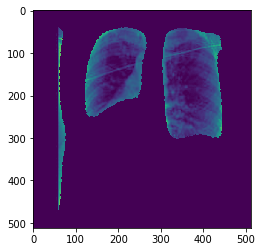

In [ ]:
plt.imshow(np.squeeze(t[4]))

In [ ]:
np.savez_compressed('/kaggle/working/lungs.npz', t)